## Model Development

Melakukan import library yang dibutuhkan

In [22]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import adjustText
import tensorflow_hub as hub
import seaborn as sns

Melakukan import dataset

In [3]:
df_data = pd.read_csv('../Data/data_2/clean_review_160k.csv')
df_data

,text,rating,label
0,near airport good shuttle service stay night w...,2.0,negative
1,get low rank reason positive thing say hotel s...,1.0,negative
2,budget hotel pretend resort ORG ORG really mot...,2.0,negative
3,dish extra buck stay elsewhere place look acce...,1.0,negative
4,l budget good low cost brand hotel near downto...,2.0,negative
...,...,...,...
141740,fantastic mid range hotel u find well GPE stay...,5.0,positive
141741,fantastic service staff encounter property mak...,4.0,positive
141742,great find stay DATE previously stay theatre d...,4.0,positive
141743,convenient location airport stay start road tr...,4.0,positive


### TF-IDF Method

In [4]:
negative_reviews = df_data[df_data['label'] == 'negative']['text']
positive_reviews = df_data[df_data['label'] == 'positive']['text']
neutral_reviews = df_data[df_data['label'] == 'neutral']['text']


all_reviews = df_data['text']

vectorizer = TfidfVectorizer()
tfidf_all = vectorizer.fit_transform(all_reviews)

tfidf_negative = vectorizer.transform(negative_reviews)
tfidf_positive = vectorizer.transform(positive_reviews)
tfidf_neutral = vectorizer.transform(neutral_reviews)

top_words_negative = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_negative.toarray(), axis=0))} 
top_words_positive = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_positive.toarray(), axis=0))}
top_words_neutral = {word: score for word, score in zip(vectorizer.get_feature_names_out(), np.max(tfidf_neutral.toarray(), axis=0))}

wordcloud_negative = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_negative)
wordcloud_positive = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_positive)
wordcloud_neutral = WordCloud(max_font_size = 160, margin=0, background_color = "white").generate_from_frequencies(top_words_neutral)

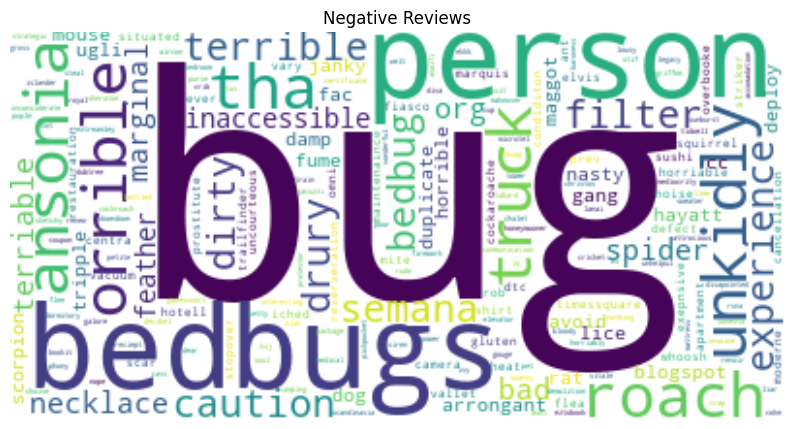

In [5]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Reviews')
plt.axis("off")
plt.show()


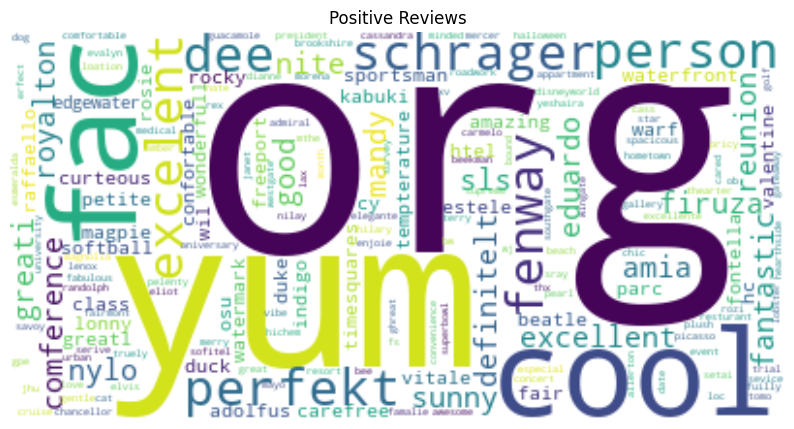

In [6]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Reviews')
plt.axis("off")
plt.show()


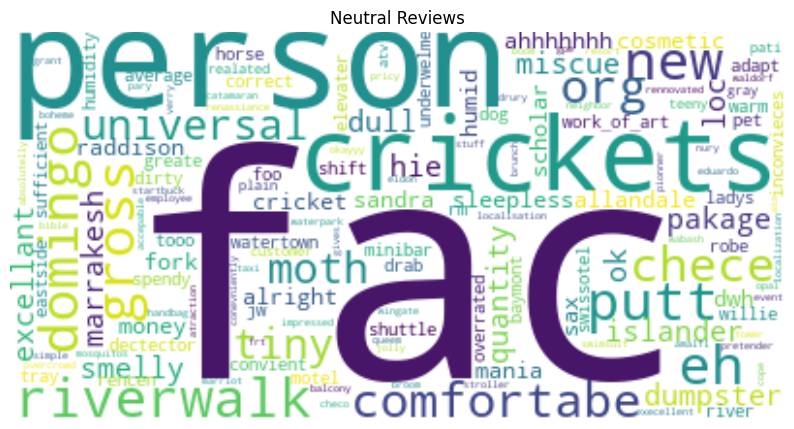

In [7]:
plt.figure(figsize=[10,10])
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.title('Neutral Reviews')
plt.axis("off")
plt.show()

In [8]:
encoding_5label = {
    'positive': 0,
    'neutral': 1,
    'negative': 2
}


In [9]:
df_data['label'] = df_data['label'].map(encoding_5label)
df_data

,text,rating,label
0,near airport good shuttle service stay night w...,2.0,2
1,get low rank reason positive thing say hotel s...,1.0,2
2,budget hotel pretend resort ORG ORG really mot...,2.0,2
3,dish extra buck stay elsewhere place look acce...,1.0,2
4,l budget good low cost brand hotel near downto...,2.0,2
...,...,...,...
141740,fantastic mid range hotel u find well GPE stay...,5.0,0
141741,fantastic service staff encounter property mak...,4.0,0
141742,great find stay DATE previously stay theatre d...,4.0,0
141743,convenient location airport stay start road tr...,4.0,0


In [10]:
x_train, x_test, y_train, y_test = train_test_split(df_data['text'], df_data['label'], test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_val.shape, y_val.shape

((113396,), (14174,), (113396,), (14174,), (14175,), (14175,))

In [13]:
x_train_tensor = tf.convert_to_tensor(x_train)
y_train_tensor = tf.convert_to_tensor(y_train)
x_test_tensor = tf.convert_to_tensor(x_test)
y_test_tensor = tf.convert_to_tensor(y_test)
x_val_tensor = tf.convert_to_tensor(x_val)
y_val_tensor = tf.convert_to_tensor(y_val)

In [16]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_LABELS, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_2 (Dense)             (None, 64)                3264      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 48,194,059
Trainable params: 48,194,059
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = model.fit(x_train_tensor, y_train_tensor, epochs=10, batch_size=256, validation_data=(x_test_tensor, y_test_tensor))

Epoch 1/10
443/443 [==============================] - 310s 699ms/step - loss: 0.6850 - accuracy: 0.7183 - val_loss: 0.5532 - val_accuracy: 0.7770
Epoch 2/10
443/443 [==============================] - 295s 666ms/step - loss: 0.5371 - accuracy: 0.7882 - val_loss: 0.5329 - val_accuracy: 0.7827
Epoch 3/10
443/443 [==============================] - 304s 686ms/step - loss: 0.4991 - accuracy: 0.8045 - val_loss: 0.5325 - val_accuracy: 0.7781
Epoch 4/10
443/443 [==============================] - 295s 667ms/step - loss: 0.4718 - accuracy: 0.8154 - val_loss: 0.5317 - val_accuracy: 0.7792
Epoch 5/10
443/443 [==============================] - 290s 656ms/step - loss: 0.4506 - accuracy: 0.8256 - val_loss: 0.5405 - val_accuracy: 0.7757
Epoch 6/10
443/443 [==============================] - 288s 649ms/step - loss: 0.4296 - accuracy: 0.8351 - val_loss: 0.5557 - val_accuracy: 0.7711
Epoch 7/10
443/443 [==============================] - 290s 654ms/step - loss: 0.4114 - accuracy: 0.8439 - val_loss: 0.5728 -

In [18]:
val_loss, val_accuracy = model.evaluate(x_val_tensor, y_val_tensor)

443/443 [==============================] - 39s 89ms/step - loss: 0.6350 - accuracy: 0.7596


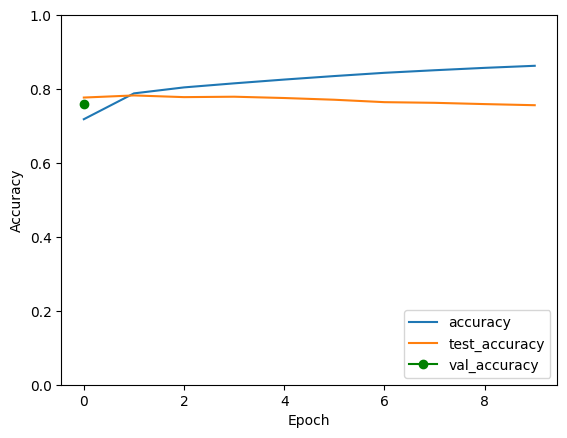

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.plot(val_accuracy, label='val_accuracy',marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

In [20]:
predictions = model.predict(x_val_tensor)
predictions = np.argmax(predictions, axis=1)
conf_matrix = confusion_matrix(y_val, predictions)

443/443 [==============================] - 38s 86ms/step


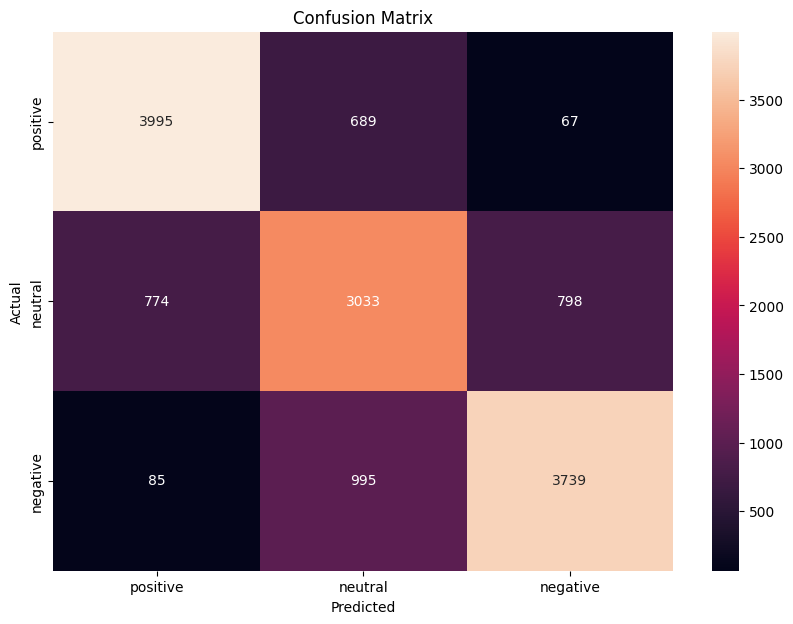

In [23]:
df_confusion_matrix = pd.DataFrame(conf_matrix, index = ['positive', 'neutral', 'negative'], columns = ['positive', 'neutral', 'negative'])
plt.figure(figsize=(10,7))
plt.title('Confusion Matrix')
sns.heatmap(df_confusion_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
embeddings = model.layers[0].get_weights()[0]
pca = PCA(n_components=10, random_state=42).fit_transform(embeddings)
embeddings_2d = TSNE(n_components=2, random_state=42, perplexity=35).fit_transform(pca)

magnitudes = np.linalg.norm(embeddings, axis=1)
top_indices = magnitudes.argsort()[-200:]
top_words = {word: index for word, index in word_index.items() if index in top_indices}

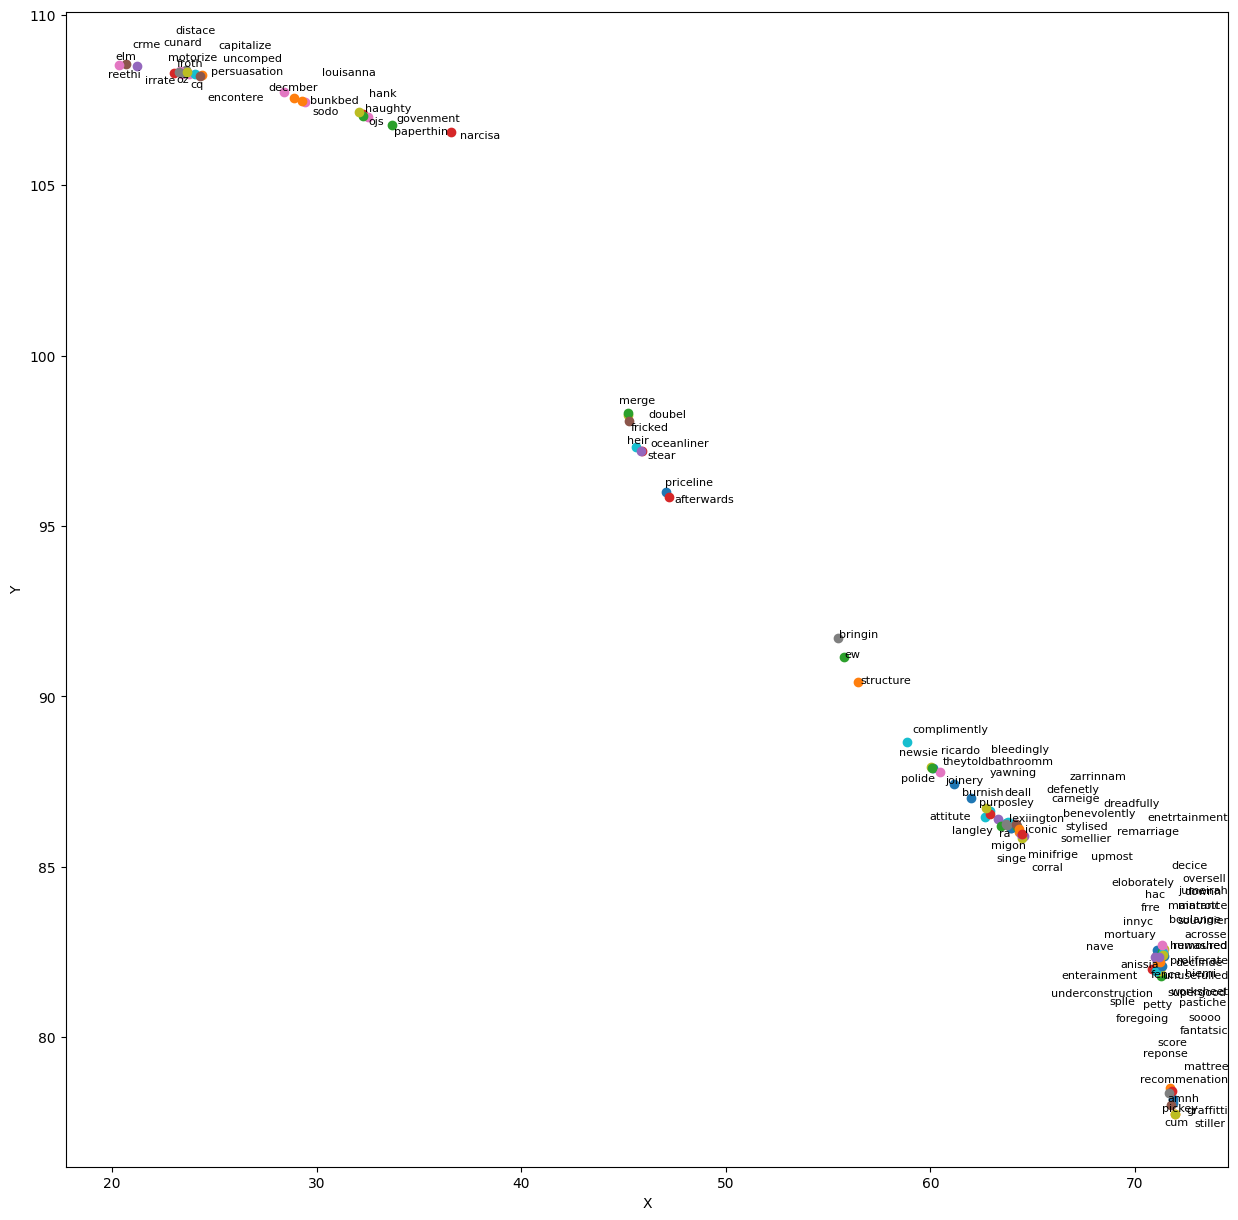

In [ ]:
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111)

for word, index in top_words.items():
    x, y = embeddings_2d[index]
    ax.scatter(x, y)
    ax.text(x, y, word, fontsize=8)

ax.set_xlabel('X')
ax.set_ylabel('Y')
adjustText.adjust_text(ax.texts,iterations=100)

plt.show()

In [ ]:
model.save('model_2.h5')